### Installing the dependencies

In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [2]:
!pip list

Package                                  Version
---------------------------------------- --------------------
absl-py                                  1.4.0
accelerate                               0.28.0
affine                                   2.4.0
aiohttp                                  3.8.5
aiosignal                                1.3.1
alabaster                                0.7.12
albumentations                           1.3.1
alpha-vantage                            2.3.1
altair                                   5.2.0
anaconda-client                          1.11.2
anaconda-navigator                       2.4.0
anaconda-project                         0.11.1
annotated-types                          0.6.0
anyio                                    3.5.0
appdirs                                  1.4.4
applaunchservices                        0.3.0
appnope                                  0.1.2
appscript                                1.1.2
argon2-cffi                            

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import imageio

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

### Build Data Loading Function

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output , quiet = False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=9e291ddb-1b8a-4b76-a57b-4a6c1bf37e99
To: /Users/anishsoni/Desktop/LipNet/data.zip
100%|████████████████████████████████████████| 423M/423M [01:52<00:00, 3.76MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range (int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames-mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789"]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary = vocab, oov_token = "")
num_to_char = tf.keras.layers.StringLookup(vocabulary = char_to_num.get_vocabulary(), oov_token="", invert = True)

print(f"The vocabulary is : {char_to_num.get_vocabulary()}"
      f"(size = {char_to_num.vocabulary_size()})"
     )


The vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9'](size = 39)


In [ ]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [ ]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [ ]:
num_to_char([14,9,3,11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [ ]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [ ]:
test_path = './data/s1/bbal6n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

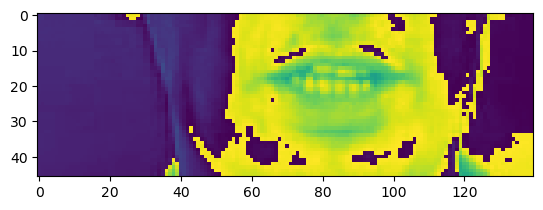

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14,  0,  2, 12, 21,  5,  0,  1, 20,  0, 12,  0, 19,  9, 24,
        0, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'binblueatlsixnow'>

In [ ]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

### Create Data Pipeline

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*mpg')
data = data.shuffle(500, reshuffle_each_iteration= False)
data = data.map(mappable_function)
data = data.prefetch(tf.data.AUTOTUNE)
#Added for split
train = data.take(450)
test = data.skip(450)

In [ ]:
len(test)

550

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

75

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

array([[[[ 1.4136487 ],
         [ 1.4136487 ],
         [ 1.4540387 ],
         ...,
         [ 0.08077993],
         [ 0.20194982],
         [ 0.16155986]],

        [[ 1.4136487 ],
         [ 1.4136487 ],
         [ 1.4540387 ],
         ...,
         [ 0.04038997],
         [ 0.16155986],
         [ 0.08077993]],

        [[ 1.2924789 ],
         [ 1.2924789 ],
         [ 1.2924789 ],
         ...,
         [10.299441  ],
         [10.299441  ],
         [10.299441  ]],

        ...,

        [[ 0.96935916],
         [ 0.96935916],
         [ 0.96935916],
         ...,
         [10.057101  ],
         [10.057101  ],
         [10.057101  ]],

        [[ 0.9289692 ],
         [ 0.9289692 ],
         [ 0.9289692 ],
         ...,
         [10.057101  ],
         [10.057101  ],
         [10.057101  ]],

        [[ 0.9289692 ],
         [ 0.9289692 ],
         [ 0.9289692 ],
         ...,
         [10.057101  ],
         [10.057101  ],
         [10.057101  ]]],


       [[[ 1.3732588 ],


In [ ]:
image_data = val[0][0]
image_data_uint8 = image_data.astype(np.uint8)
imageio.mimsave('./animation.gif', [image_data_uint8], fps=10)

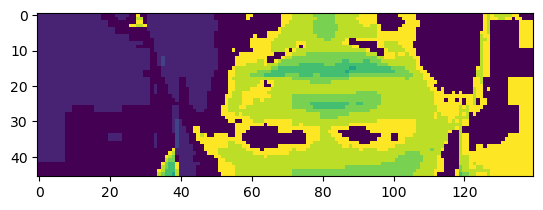

In [ ]:
plt.imshow(image_data_uint8)

In [ ]:
import tensorflow as tf

def num_to_char(num):
    return str(num)

# Example data
val = [[1, 2, 3], [456, 789]]

# Ensure val[1][0] is always an iterable list
num_list = [val[1][0]] if not isinstance(val[1][0], (list, tuple)) else val[1][0]

# Convert num_list[0] to a list if it's not already iterable
char_list = [num_to_char(digit) for digit in str(num_list[0])]

# Join the characters using tf.strings.reduce_join
result = tf.strings.reduce_join(char_list)
print(result)

tf.Tensor(b'456', shape=(), dtype=string)


### Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(46, 140, 1)

In [ ]:
# batch_size = 1
# num_frames = 75
# height = 46
# width = 140
# depth = 1
input_data = np.random.rand(batch_size, num_frames, height, width, depth)

# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv3D(128, (3, 3, 3), input_shape=(num_frames, height, width, depth), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(Conv3D(75, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

# TimeDistributed layer to apply Flatten to each frame
model.add(TimeDistributed(Flatten()))

# Recurrent layers
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))

# Compile the model (replace loss and optimizer with your choice)
model.compile(loss='categorical_crossentropy', optimizer='adam')

NameError: name 'batch_size' is not defined

In [ ]:
model.summary()

In [ ]:
!pip install pydot
!pip install graphviz

In [ ]:
#plotting the model
tf.keras.utils.plot_model(model, to_file='model_viz.png', show_shapes=True)

In [ ]:
# Print model summary
model.summary()

In [ ]:
# Making Predictions
yhat = model.predict(input_data)

print(yhat.shape)

In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

In [ ]:
model.input_shape

In [ ]:
model.output_shape

### Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

### Make a prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
import tensorflow as tf
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

### Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]